In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from architectures import *
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from utils import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 37
ROOT_PATH = os.getcwd()
os.makedirs(DATASET_PATH := os.path.join(ROOT_PATH, "dataset"), exist_ok=True)
os.makedirs(MODELS_PATH := os.path.join(ROOT_PATH, "models"), exist_ok=True)

BATCH_SIZE = 32
TRAIN_RATIO, DEV_RATIO, TEST_RATIO = 0.8, 0.1, 0.1
LBP_ENGINEERING = False

LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 7

seed_functions(SEED)

c:\Users\gregory\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


Loading

In [ ]:
T = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = datasets.ImageFolder(DATASET_PATH, transform=T)

def split_data(dataset):
	labels = [tp[1] for tp in dataset]
	train_set, temp_set = train_test_split(dataset, test_size=(1 - TRAIN_RATIO), random_state=SEED, stratify=labels)
	temp_labels = [tp[1] for tp in temp_set]
	test_set, dev_set = train_test_split(temp_set, test_size=(TEST_RATIO / (DEV_RATIO + TEST_RATIO)), random_state=SEED, stratify=temp_labels)
	if LBP_ENGINEERING:
		return LBPDataset(train_set), LBPDataset(dev_set), LBPDataset(test_set)
	return train_set, dev_set, test_set

train_set, dev_set, test_set = split_data(dataset)

train_generator = torch.Generator().manual_seed(SEED)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, generator=train_generator)
dev_loader = torch.utils.data.DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Training

In [3]:
model = SR50ViTB16().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [4]:
def train_model(model, train_loader, dev_loader, criterion, optimizer):
	# Create model folder
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	os.makedirs(model_folder, exist_ok=True)

	best_dev_loss = float("inf")
	best_model_path = os.path.join(model_folder, "best.pth")
	patience_counter = 0
	train_losses = []
	dev_losses = []

	for epoch in range(NUM_EPOCHS):
		# Train model on train set
		model.train()
		total_loss = 0
		for images, labels in train_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
		train_loss = total_loss / len(train_loader)
		train_losses.append(train_loss)

		# Evaluate model on dev set
		model.eval()
		dev_loss = 0
		with torch.no_grad():
			for images, labels in dev_loader:
				images, labels = images.to(DEVICE), labels.to(DEVICE)
				outputs = model(images)
				dev_loss += criterion(outputs, labels).item()
		dev_loss /= len(dev_loader)
		dev_losses.append(dev_loss)

		print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} - Dev Loss: {dev_loss:.4f}")

		# Save model epoch checkpoint
		torch.save(model.state_dict(), os.path.join(model_folder, f"epoch={epoch+1}-dev_loss={dev_loss:.4f}.pth"))

		if dev_loss < best_dev_loss:
			best_dev_loss = dev_loss
			torch.save(model.state_dict(), best_model_path)  # Save best model
			patience_counter = 0  # Reset patience counter
		else:
			patience_counter += 1
			# Stop early if needed
			if patience_counter >= PATIENCE:
				print("Stopping early")
				break

	# Save losses
	loss_data = {"train_losses": train_losses, "dev_losses": dev_losses}
	with open(os.path.join(model_folder, "losses.json"), "w") as f:
		json.dump(loss_data, f)

train_model(model, train_loader, dev_loader, criterion, optimizer)

Epoch 1/50 - Train Loss: 0.8366 - Dev Loss: 0.5229
Epoch 2/50 - Train Loss: 0.5398 - Dev Loss: 0.5593
Epoch 3/50 - Train Loss: 0.5370 - Dev Loss: 0.5416
Epoch 4/50 - Train Loss: 0.5676 - Dev Loss: 0.5846
Epoch 5/50 - Train Loss: 0.5812 - Dev Loss: 0.5184
Epoch 6/50 - Train Loss: 0.4957 - Dev Loss: 0.4810
Epoch 7/50 - Train Loss: 0.4763 - Dev Loss: 0.4646
Epoch 8/50 - Train Loss: 0.5819 - Dev Loss: 0.5527
Epoch 9/50 - Train Loss: 0.5165 - Dev Loss: 0.5299
Epoch 10/50 - Train Loss: 0.5178 - Dev Loss: 0.5272
Epoch 11/50 - Train Loss: 0.5244 - Dev Loss: 0.5666
Epoch 12/50 - Train Loss: 0.5172 - Dev Loss: 0.5622
Epoch 13/50 - Train Loss: 0.5184 - Dev Loss: 0.4938
Epoch 14/50 - Train Loss: 0.4901 - Dev Loss: 0.5164
Stopping early


Post-training

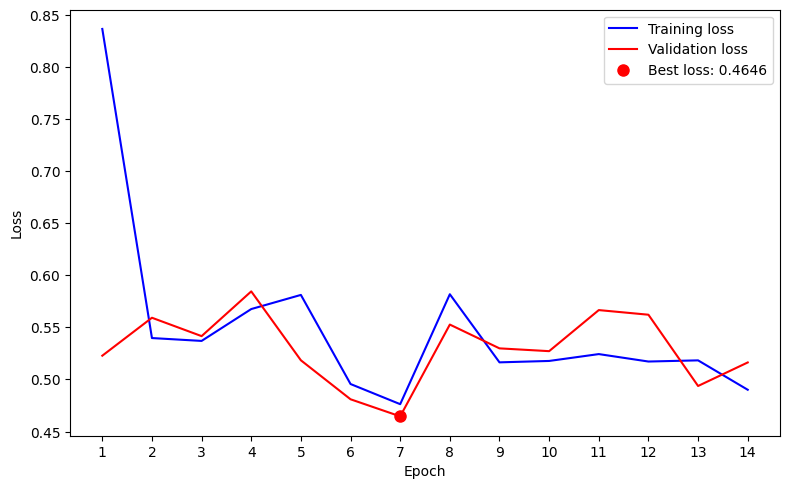

{'tp': 158, 'tn': 0, 'fp': 43, 'fn': 0, 'f1': 0.8802228412256268}


In [5]:
def visualise_loss(model):
	# Load losses
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	with open(os.path.join(model_folder, "losses.json"), "r") as f:
		loss_data = json.load(f)
	train_losses = loss_data["train_losses"]
	dev_losses = loss_data["dev_losses"]

	plt.figure(figsize=(8, 5))
	epochs = range(1, len(train_losses) + 1)
	plt.plot(epochs, train_losses, "b-", label="Training loss")
	plt.plot(epochs, dev_losses, "r-", label="Validation loss")

	# Annotate the best loss
	best_epoch = np.argmin(dev_losses) + 1
	best_loss = min(dev_losses)
	plt.plot(best_epoch, best_loss, "ro", markersize=8, label=f"Best loss: {best_loss:.4f}")

	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
	plt.tight_layout()
	plt.show()

def evaluate_model(model, dataloader):
	model.eval()
	Y_hat, Y = [], []
	with torch.no_grad():
		for x, y in dataloader:
			logits = model(x.to(DEVICE))
			Y_hat.append(torch.argmax(logits, dim=1).cpu())
			Y.append(y.view(-1))
	tn, fp, fn, tp = confusion_matrix(torch.cat(Y), torch.cat(Y_hat)).ravel()
	f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 0
	return {
		"tp": int(tp),
		"tn": int(tn),
		"fp": int(fp),
		"fn": int(fn),
		"f1": float(f1)
	}

m = model.__class__().to(DEVICE)
visualise_loss(m)

m.load_state_dict(torch.load(os.path.join(MODELS_PATH, m.id, "best.pth")))
print(evaluate_model(m, test_loader))